<a id='0'></a>
# Part 1. Problem Definition

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

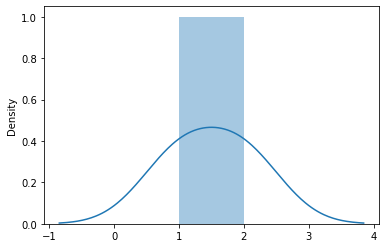

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: 
* Reward function: 
* State: 
* Environment: 

<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages

In [3]:
!pip install -r requirements.txt --user

  Cloning git://github.com/quantopian/pyfolio (to revision master) to /private/var/folders/_4/4l2h0xdn6n1d86jjq29rfqdm0000gp/T/pip-req-build-o3f50u3a
  Running command git clone -q git://github.com/quantopian/pyfolio /private/var/folders/_4/4l2h0xdn6n1d86jjq29rfqdm0000gp/T/pip-req-build-o3f50u3a
distutils: /Users/davidpedros/Library/Python/3.8/lib/python/site-packages
sysconfig: /Users/davidpedros/Library/Python/3.8/lib/python3.8/site-packages
distutils: /Users/davidpedros/Library/Python/3.8/lib/python/site-packages
sysconfig: /Users/davidpedros/Library/Python/3.8/lib/python3.8/site-packages
distutils: /Users/davidpedros/Library/Python/3.8/include/python3.8/UNKNOWN
sysconfig: /Users/davidpedros/Library/Python/3.8/include/python3.8
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


<a id='1.2'></a>
## 2.2. Import Packages

In [87]:
%load_ext autoreload
%autoreload 
import pandas as pd
from config import config
from dataset.download_dataset.cryptodownloader_binance import CryptoDownloader_binance
from preprocessing.preprocessors import FeatureEngineer
from preprocessing.data import data_split
from env.env_portfolio import StockPortfolioEnv
from model.models import DRLAgent
from trade.backtest import BackTest
import warnings
warnings.filterwarnings("ignore")

# from trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='1.3'></a>
## 2.3 Create Folders

In [8]:
import os
download_data = False
if not os.path.exists(config.DATA_SAVE_DIR):
    os.makedirs(config.DATA_SAVE_DIR)
    download_data = True
if not os.path.exists(config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists(config.TENSORBOARD_LOG_DIR):
    os.makedirs(config.TENSORBOARD_LOG_DIR)
if not os.path.exists(config.RESULTS_DIR):
    os.makedirs(config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data

In [118]:
data_downloader = CryptoDownloader_binance(config.START_DATE, config.END_DATE, config.MULTIPLE_TICKER_8, config.DATA_SAVE_DIR, config.DATA_GRANULARITY)
if download_data:    
    data_downloader.download_data()
df = data_downloader.load()

# Part 4: Preprocess Data

In [119]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [120]:
df

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2020-01-01 00:00:00,0.032850,0.032850,0.032700,0.032780,1.166001e+06,ada,0.000000,0.033182,0.032588,100.000000,66.666667,100.000000,0.032780,0.032780
10944,2020-01-01 00:00:00,13.715900,13.721100,13.690300,13.698100,6.201669e+04,bnb,0.000000,0.033182,0.032588,100.000000,66.666667,100.000000,13.698100,13.698100
21888,2020-01-01 00:00:00,7195.240000,7196.250000,7175.460000,7177.020000,5.118149e+02,btc,0.000000,0.033182,0.032588,100.000000,66.666667,100.000000,7177.020000,7177.020000
32832,2020-01-01 00:00:00,1.000000,1.000000,1.000000,1.000000,3.555110e+06,cash,0.000000,0.033182,0.032588,100.000000,66.666667,100.000000,1.000000,1.000000
43776,2020-01-01 00:00:00,0.002014,0.002023,0.002008,0.002008,9.630910e+05,doge,0.000000,0.033182,0.032588,100.000000,66.666667,100.000000,0.002008,0.002008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54719,2021-03-31 23:00:00,0.053143,0.053911,0.053000,0.053770,4.448111e+07,doge,-0.000103,0.054076,0.052762,50.006619,-10.311768,28.977404,0.053646,0.053938
65663,2021-03-31 23:00:00,1903.970000,1924.210000,1901.620000,1919.370000,2.122478e+04,eth,26.214167,1948.647647,1762.109353,64.618395,164.610885,23.659415,1851.563000,1833.205500
76607,2021-03-31 23:00:00,28.571700,29.440100,28.550100,29.416700,4.557268e+05,link,0.276832,29.035767,26.359743,64.396467,226.662894,36.167462,27.746403,27.922328
87551,2021-03-31 23:00:00,194.620000,197.630000,194.470000,196.700000,2.863109e+04,ltc,0.332601,198.176985,188.501015,55.327678,76.382622,7.269085,194.139000,194.302667


## Add covariance matrix as states

In [121]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  covs = return_lookback.cov().values 
  cov_list.append(covs)
  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
        

In [122]:
df

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list
0,2020-01-11 12:00:00,0.036630,0.036690,0.036410,0.036670,2.592805e+06,ada,0.000161,0.037216,0.036439,52.376747,21.688680,6.352014,0.036447,0.036144,"[[4.0233926408305706e-05, 2.8237340102521616e-..."
1,2020-01-11 12:00:00,14.868600,14.920900,14.820000,14.900300,1.779574e+04,bnb,0.081623,15.056803,14.767107,55.593186,39.729960,9.388623,14.757783,14.569318,"[[4.0233926408305706e-05, 2.8237340102521616e-..."
2,2020-01-11 12:00:00,8045.890000,8068.000000,8018.410000,8061.950000,1.788465e+03,btc,33.263463,8225.486259,7967.135741,52.997601,22.549125,20.526702,8015.934667,7941.340667,"[[4.0233926408305706e-05, 2.8237340102521616e-..."
3,2020-01-11 12:00:00,1.000000,1.000000,1.000000,1.000000,5.519696e+06,cash,0.000000,1.000000,1.000000,52.559473,8.269112,16.667396,1.000000,1.000000,"[[4.0233926408305706e-05, 2.8237340102521616e-..."
4,2020-01-11 12:00:00,0.002179,0.002184,0.002174,0.002174,1.427073e+06,doge,0.000007,0.002217,0.002161,52.559473,8.269112,16.667396,0.002176,0.002146,"[[4.0233926408305706e-05, 2.8237340102521616e-..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96223,2021-03-31 23:00:00,0.053143,0.053911,0.053000,0.053770,4.448111e+07,doge,-0.000103,0.054076,0.052762,50.006619,-10.311768,28.977404,0.053646,0.053938,"[[0.0001184825404164931, 7.09745373279422e-05,..."
96224,2021-03-31 23:00:00,1903.970000,1924.210000,1901.620000,1919.370000,2.122478e+04,eth,26.214167,1948.647647,1762.109353,64.618395,164.610885,23.659415,1851.563000,1833.205500,"[[0.0001184825404164931, 7.09745373279422e-05,..."
96225,2021-03-31 23:00:00,28.571700,29.440100,28.550100,29.416700,4.557268e+05,link,0.276832,29.035767,26.359743,64.396467,226.662894,36.167462,27.746403,27.922328,"[[0.0001184825404164931, 7.09745373279422e-05,..."
96226,2021-03-31 23:00:00,194.620000,197.630000,194.470000,196.700000,2.863109e+04,ltc,0.332601,198.176985,188.501015,55.327678,76.382622,7.269085,194.139000,194.302667,"[[0.0001184825404164931, 7.09745373279422e-05,..."


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2020-01-01 to 2020-12-31

In [123]:
train = data_split(df, '2020-01-01','2020-12-31')

## Environment for Portfolio Allocation


In [124]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.1, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

env_train, _ = e_train_gym.get_sb_env()

Stock Dimension: 9, State Space: 9


<a id='5'></a>
# Part 6: Implement DRL Algorithms

In [140]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [126]:
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [142]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=60000)

Logging to ./tensorboard_log/a2c/a2c_12
------------------------------------
| time/                 |          |
|    fps                | 622      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -12.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.002    |
|    n_updates          | 99       |
|    policy_loss        | 9.99e+07 |
|    std                | 0.98     |
|    value_loss         | 7.86e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 627      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -12.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.002    |
|    n_updates          | 199      

### Model 2: **PPO**

In [128]:
# agent = DRLAgent(env = env_train)
# PPO_PARAMS = {
#     "n_steps": 2048,
#     "ent_coef": 0.005,
#     "learning_rate": 0.0001,
#     "batch_size": 128,
# }
# model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

In [129]:
# trained_ppo = agent.train_model(model=model_ppo, 
#                              tb_log_name='ppo',
#                              total_timesteps=80000)

## Trading
Assume that we have $1,000,000 initial capital at 2021-01-01.

In [143]:
trade = data_split(df,config.START_TEST_DATE, config.END_DATE)
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [144]:
trade.shape

(19440, 16)

In [145]:
trade

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list
0,2021-01-01 00:00:00,0.181340,0.181460,0.178310,0.180510,1.919492e+07,ada,-0.000153,0.184657,0.176516,50.750459,-27.165052,6.100618,0.180782,0.182191,"[[0.0002349149383179099, 7.732551281244582e-05..."
0,2021-01-01 00:00:00,37.359600,37.442300,36.963600,37.376400,9.511383e+04,bnb,-0.083237,37.946399,36.719461,51.231566,-33.515795,11.715168,37.421230,37.590240,"[[0.0002349149383179099, 7.732551281244582e-05..."
0,2021-01-01 00:00:00,28923.630000,29031.340000,28690.170000,28995.130000,2.311811e+03,btc,133.938215,29333.932277,28372.364723,57.001762,31.346237,5.617701,28857.221667,28217.099500,"[[0.0002349149383179099, 7.732551281244582e-05..."
0,2021-01-01 00:00:00,1.000000,1.000000,1.000000,1.000000,8.910403e+07,cash,0.000000,1.000000,1.000000,53.910140,48.169530,6.372370,1.000000,1.000000,"[[0.0002349149383179099, 7.732551281244582e-05..."
0,2021-01-01 00:00:00,0.004672,0.004701,0.004601,0.004679,2.768207e+07,doge,0.000018,0.004729,0.004558,53.910140,48.169530,6.372370,0.004639,0.004574,"[[0.0002349149383179099, 7.732551281244582e-05..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,2021-03-31 23:00:00,0.053143,0.053911,0.053000,0.053770,4.448111e+07,doge,-0.000103,0.054076,0.052762,50.006619,-10.311768,28.977404,0.053646,0.053938,"[[0.0001184825404164931, 7.09745373279422e-05,..."
2159,2021-03-31 23:00:00,1903.970000,1924.210000,1901.620000,1919.370000,2.122478e+04,eth,26.214167,1948.647647,1762.109353,64.618395,164.610885,23.659415,1851.563000,1833.205500,"[[0.0001184825404164931, 7.09745373279422e-05,..."
2159,2021-03-31 23:00:00,28.571700,29.440100,28.550100,29.416700,4.557268e+05,link,0.276832,29.035767,26.359743,64.396467,226.662894,36.167462,27.746403,27.922328,"[[0.0001184825404164931, 7.09745373279422e-05,..."
2159,2021-03-31 23:00:00,194.620000,197.630000,194.470000,196.700000,2.863109e+04,ltc,0.332601,198.176985,188.501015,55.327678,76.382622,7.269085,194.139000,194.302667,"[[0.0001184825404164931, 7.09745373279422e-05,..."


In [151]:
hourly_returns, hourly_actions, hourly_allocation = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:3420303.9294909304
Sharpe:  0.8893562826901523
hit end!


In [152]:
hourly_returns

,date,daily_return
0,2021-01-01 00:00:00,0.000000
1,2021-01-01 01:00:00,0.016615
2,2021-01-01 02:00:00,0.000811
3,2021-01-01 03:00:00,0.004204
4,2021-01-01 04:00:00,0.005315
...,...,...
2155,2021-03-31 19:00:00,-0.005584
2156,2021-03-31 20:00:00,0.013082
2157,2021-03-31 21:00:00,-0.000778
2158,2021-03-31 22:00:00,0.000558


In [153]:
df_actions

,ada,bnb,btc,cash,doge,eth,link,ltc,xrp
date,,,,,,,,,
2021-01-01 00:00:00,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
2021-01-01 01:00:00,0.063000,0.063000,0.171251,0.063000,0.063000,0.171251,0.171251,0.063000,0.171251
2021-01-01 02:00:00,0.063000,0.063000,0.171251,0.063000,0.063000,0.171251,0.171251,0.063000,0.171251
2021-01-01 03:00:00,0.063000,0.063000,0.171251,0.063000,0.063000,0.171251,0.171251,0.063000,0.171251
2021-01-01 04:00:00,0.063000,0.063000,0.171251,0.063000,0.063000,0.171251,0.171251,0.063000,0.171251
...,...,...,...,...,...,...,...,...,...
2021-03-31 19:00:00,0.063000,0.063000,0.171251,0.063000,0.063000,0.171251,0.171251,0.063000,0.171251
2021-03-31 20:00:00,0.063000,0.063000,0.171251,0.063000,0.063000,0.171251,0.171251,0.063000,0.171251
2021-03-31 21:00:00,0.063000,0.063000,0.171251,0.063000,0.063000,0.171251,0.171251,0.063000,0.171251


In [154]:
hourly_allocation

,ada,bnb,btc,cash,doge,eth,link,ltc,xrp
date,,,,,,,,,
2021-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-01 01:00:00,64046.265625,64046.265625,174095.812500,64046.265625,64046.265625,174095.812500,174095.812500,64046.265625,174095.812500
2021-01-01 02:00:00,64098.199219,64098.199219,174236.984375,64098.199219,64098.199219,174236.984375,174236.984375,64098.199219,174236.984375
2021-01-01 03:00:00,64367.683594,64367.683594,174969.515625,64367.683594,64367.683594,174969.515625,174969.515625,64367.683594,174969.515625
2021-01-01 04:00:00,64709.796875,64709.796875,175899.468750,64709.796875,64709.796875,175899.468750,175899.468750,64709.796875,175899.468750
...,...,...,...,...,...,...,...,...,...
2021-03-31 19:00:00,211289.281250,211289.281250,574343.812500,211289.281250,211289.281250,574343.812500,574343.812500,211289.281250,574343.812500
2021-03-31 20:00:00,214053.265625,214053.265625,581857.125000,214053.265625,214053.265625,581857.125000,581857.125000,214053.265625,581857.125000
2021-03-31 21:00:00,213886.703125,213886.703125,581404.375000,213886.703125,213886.703125,581404.375000,581404.375000,213886.703125,581404.375000


In [137]:
df_actions.to_csv('df_actions.csv')

<a id='6'></a>
# Part 7: Backtest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
begin_total_asset:1000000
end_total_asset:3431869.8970882893
Sharpe:  0.891510831899833
hit end!


Start date,2021-01-01
End date,2021-03-31
Total months,4
,Backtest
Annual return,3058.539%
Cumulative returns,243.187%
Annual volatility,78.519%
Sharpe ratio,4.81
Calmar ratio,155.44
Stability,0.83
Max drawdown,-19.676%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.68,2021-02-19,2021-02-28,2021-03-31,29
1,14.99,2021-01-09,2021-01-12,2021-01-18,6
2,13.07,2021-01-20,2021-01-21,2021-01-28,7
3,5.86,2021-02-13,2021-02-16,2021-02-18,4
4,0.85,2021-01-31,2021-02-01,2021-02-02,2


Stress Events,mean,min,max
New Normal,1.50%,-13.07%,20.05%


Top 10 long positions of all time,max
btc,17.13%
eth,17.13%
link,17.13%
xrp,17.13%
ltc,8.32%
ada,6.30%
bnb,6.30%
doge,6.30%


Top 10 short positions of all time,max


Top 10 positions of all time,max
btc,17.13%
eth,17.13%
link,17.13%
xrp,17.13%
ltc,8.32%
ada,6.30%
bnb,6.30%
doge,6.30%


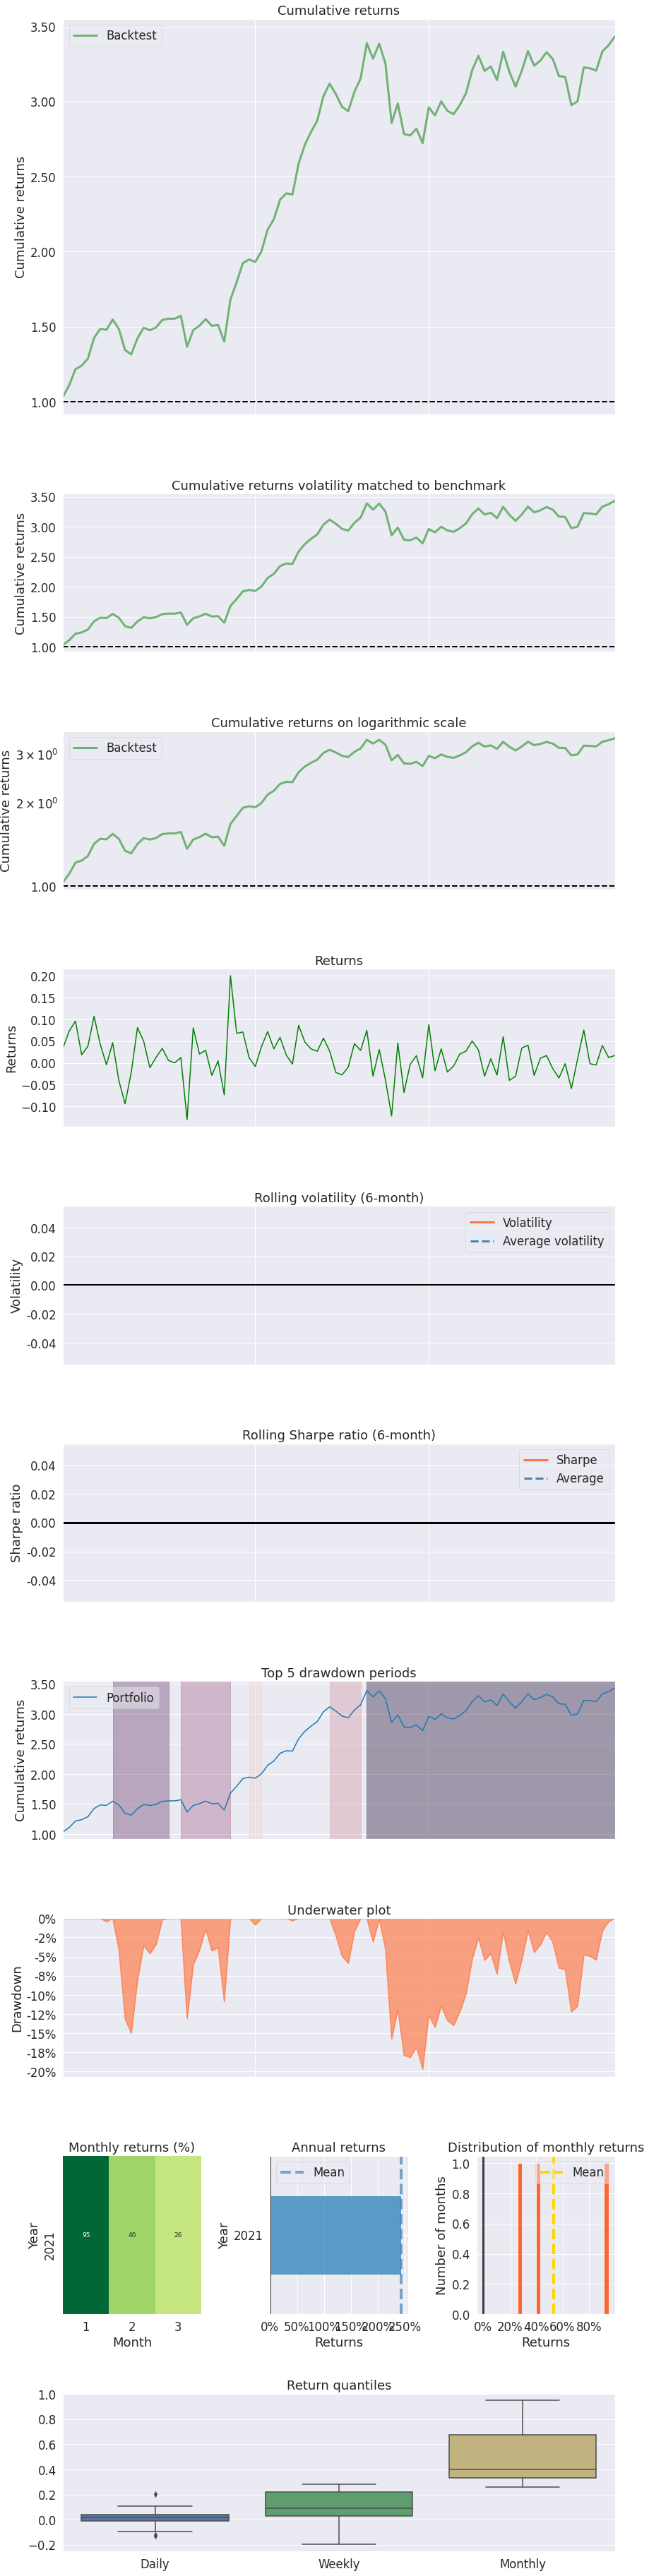

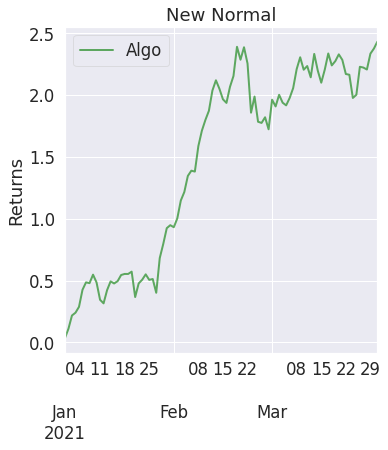

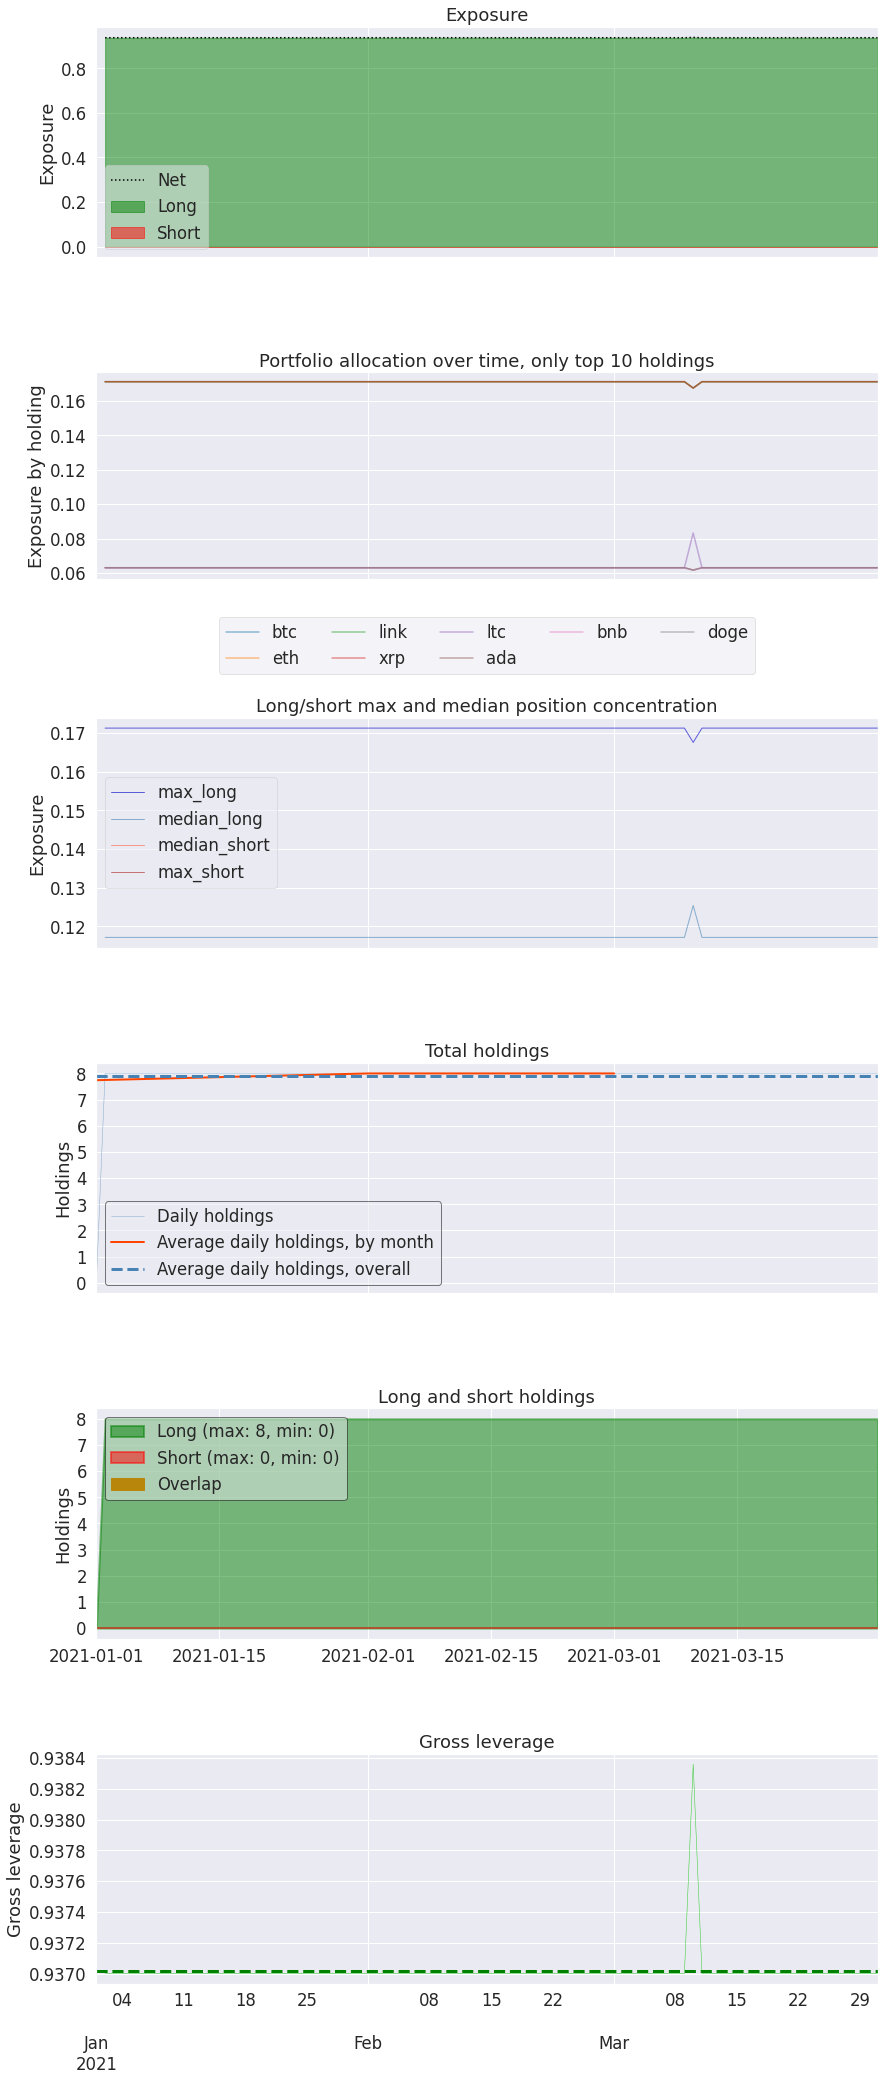

In [150]:
%load_ext autoreload
%autoreload 
bat = BackTest(trained_a2c, e_trade_gym)
bat.run(hourly_returns, hourly_allocation)